# BSc Thesis: Evaluation of Decision Tree and Random Forest Classifiers in the Finance Domain

Chapters 0 to 3 provide functions, Chapter 4 combines these functions for convenient usage, Chapter 6 contains final evaluations
## Table of Contents
0. Preparation
1. Data Preparation Stage
2. Classification Stage
3. Evaluation Stage
4. Putting it all together
5. Visualisation
6. Final Evaluations

# 0 | Preparation

### Imports

In [1]:
# Data manipulation and arrays
import pandas as pd
import numpy as np

# Machine learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, learning_curve, GridSearchCV, RandomizedSearchCV
from sklearn import metrics

# Plottig
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import display

### Constant variables

In [2]:
# Define filenames for technology stock .CSV datasets
AAPL_DATA = "Datasets/Kaggle_SnP500_AAPL_2013-2018.csv"
AMZN_DATA = "Datasets/Kaggle_SnP500_AMZN_2013-2018.csv"
CSCO_DATA = "Datasets/Kaggle_SnP500_CSCO_2013-2018.csv"
GE_DATA = "Datasets/Kaggle_SnP500_GE_2013-2018.csv"
GOOGL_DATA = "Datasets/Kaggle_SnP500_GOOGL_2013-2018.csv"
HP_DATA = "Datasets/Kaggle_SnP500_HP_2013-2018.csv"
IBM_DATA = "Datasets/Kaggle_SnP500_IBM_2013-2018.csv"
INTC_DATA = "Datasets/Kaggle_SnP500_INTC_2013-2018.csv"
MSFT_DATA = "Datasets/Kaggle_SnP500_MSFT_2013-2018.csv"
WU_DATA = "Datasets/Kaggle_SnP500_WU_2013-2018.csv"
XRX_DATA = "Datasets/Kaggle_SnP500_XRX_2013-2018.csv"
TECH_GROUP = [AAPL_DATA, AMZN_DATA, CSCO_DATA, GE_DATA, GOOGL_DATA, HP_DATA, IBM_DATA, INTC_DATA, MSFT_DATA, WU_DATA, XRX_DATA]

# Define time horizons to compare classification results for 1-day to 1-year predictions (approx. trading days)
TIME_HORIZONS = [1, 5, 10, 20, 65, 250]

# Define verbosity
VERBOSE = False

# Centrally define if figures should be saved to ./plots/
SAVE_FIG = False

# Make code reproducible by seeding random states
RANDOM_SEED = 42

# 1 | Data Preparation Stage
- Load data and adjust columns as needed
- Extract features for technical analysis
- Define class for later classification
- Detect anomalies in the datasets
- No feature selection needed as embedded in Decision Trees (DT) and Random Forests (RF)

## 1.1 | Load Datasets
- For an apples-to-apples comparison, technology companies are analyzed (idea: companies/stocks within an industry have similar drivers)
- Selected stocks differ in price trends (upward- vs constant- vs downward trend)

In [3]:
def load_OHLC_data(filename=MSFT_DATA, time_horizons=TIME_HORIZONS, verbose=VERBOSE, save_fig=SAVE_FIG):
    """
    Loads basic stock data (date, name, open, high, low, close) from a given .CSV file and returns a corresponding DataFrame.
    Unnecessary categorical columns are dropped, and necessary columns (e.g. month as number) are added.
    """
    try:
        df = pd.read_csv(filename)
        
        if save_fig is True:
            # Visualize loaded time series data if applicable
            df["date"] = pd.to_datetime(df["date"])
            df.plot(x="date", y="close", figsize=(12,6), legend=None)
            plt.xlabel("Time [Year]")
            plt.ylabel("Price [daily closing price in USD]")
            plt.title(df["Name"][0] + "-Stock Data 2013 to 2018");
            plt.savefig("./Plots/" + df["Name"][0] + "-Stock-Price-Plot.jpeg")
        
        # Calculate base column for later class: future return of stock over given time horizon (e.g. this week's Monday to next week's Monday)
        for horizon in time_horizons:
            df["return_future_" + str(horizon) + "d"] = (df["close"].shift(-1*horizon)/df["close"])-1
        
        # Convert date to numerical month to possibly detect cyclicality (e.g. christmas effect) in time series
        df["month"] = df["date"].astype("datetime64[ns]").dt.month
        
        if verbose is True:
            print("Loaded DataFrame has the following columns:")
            for col in df:
                print("Column \'" + col + "\' with type", type(df[col][0]), ", e.g.", df[col][0])
            print("df.head():")
            print(df.head())
        
        return df
    except:
        print("Error, failed to find or load OHLC data from file with name \'"
              + filename + "\'. Please provide well-formed CSV file with OHLC stock data")

In [4]:
# df_MSFT = load_OHLC_data(MSFT_DATA)
# df_AAPL = load_OHLC_data(AAPL_DATA)
# df_GOOGL = load_OHLC_data(GOOGL_DATA)
# df_HP = load_OHLC_data(HP_DATA)
# df_IBM = load_OHLC_data(IBM_DATA)
# df_WU = load_OHLC_data(WU_DATA)
# df_XRX = load_OHLC_data(XRX_DATA)

## 1.2 | Extract Features
- Common metrics for technical analysis are calculated to be later used as features
- TBD: Use TA libary: https://github.com/bukosabino/ta

In [5]:
def extract_OHLC_features(df, time_horizons=TIME_HORIZONS):
    """
    Extract common technical stock analysis features from given OHLC stock data for distinct time horizons
    """
    # Calculate technical features for each time horizon
    for horizon in time_horizons:
#         # Future return of stock over given time horizon (e.g. this week's Monday to next week's Monday)
#         df["return_future_" + str(horizon) + "d"] = (df["close"].shift(-1*horizon)/df["close"])-1
        
        # Past return of stock over given time horizon (e.g. last week's Monday to this week's Monday)
        df["return_past_" + str(horizon) + "d"] = (df["close"].shift(horizon)/df["close"])-1
        
        # Implied volatility measured by standard deviation
        df["volatility_" + str(horizon) + "d"] = df["close"].rolling(horizon).std()
        
        # Moving averages (ma)
        df["ma_" + str(horizon) + "d"] = df["close"].rolling(horizon).mean()
        
#         Exponentially-weighted moving average (ewma)
#         df["ewma_" + str(horizon) + "d"] = pd.ewma(df["close"], span=horizon, min_periods=horizon-1)
#         df["ewma_" + str(horizon) + "d"] = df["close"].ewm(span=horizon, min_periods=horizon-1)
        
        # Momentum (absolute change in price over past horizon)
        df["momentum_" + str(horizon) + "d"] = df["close"].diff(horizon)
        
        # Rate of change during horizon period
        df["rateofchange_" + str(horizon) + "d"] = (df["close"].diff(horizon-1)) / (df["close"].shift(horizon-1))
        
#         Bollinger Bands
#         df["bollingerbands1_" + str(horizon) + "d"] = 4*df["volatility_" + str(horizon) + "d"] / df["ma_" + str(horizon) + "d"]
#         df["bollingerbands2_" + str(horizon) + "d"] = (df["close"] - df["ma_" + str(horizon) + "d"] + 2*df["volatility_" + str(horizon) + "d"]) / 4*df["volatility_" + str(horizon) + "d"]
        
        # TBD add other talib indicators from #Pivot Points, Supports and Resistances
    
    # OHLC average is used for stock price average of a given day
    df["ohlc_avg"] = df[["open", "high", "low", "close"]].mean(axis=1)
    
    # Replace NaNs with zeroes
    df = df.fillna(value=0)
    return df

In [6]:
# print("#Features before extraction:", len(df_MSFT.columns))
# df_MSFT = extract_OHLC_features(df_MSFT, TIME_HORIZONS)
# print("#Features after extraction:", len(df_MSFT.columns))
# df_AAPL = extract_OHLC_features(df_AAPL, TIME_HORIZONS)
# df_GOOGL = extract_OHLC_features(df_GOOGL, TIME_HORIZONS)
# df_HP = extract_OHLC_features(df_HP, TIME_HORIZONS)
# df_IBM = extract_OHLC_features(df_IBM, TIME_HORIZONS)
# df_WU = extract_OHLC_features(df_WU, TIME_HORIZONS)
# df_XRX = extract_OHLC_features(df_XRX, TIME_HORIZONS)

# if VERBOSE is True:
#     print("With extracted features, dfMSFT.head() now yields following format:")
#     print(df_MSFT.head())

## 1.3 | Anomaly Detection
- Anomaly defined as: ABS(return_past_1d) > threshold=5% (default)
- Such anomalies (5% threshold) occur in about 1.4% of instances for seven tech stock datasets

In [7]:
def detect_anomalies(df, verbose=VERBOSE, threshold=0.05):
    """
    Iterates through the DataFrame and prints out all dates where 1-day-return is greater than threshold=5% (default)
    """
    if verbose is True:
        print("Detecting anomalies where abs(1-day-return)>" + str(threshold*100) + " % for " + df["Name"][0])
    for i in range(len(df)):
        x = df["return_past_1d"][i]
        d = df["date"][i]
        if (abs(x) > threshold):
            global anomaly_counter
            anomaly_counter = anomaly_counter + 1
            if verbose is True:
                print("Anomaly: 1-day-return of " + str(round(x * 100, 2)) + "% on " + d.strftime("%A, %d.%m.%Y"))

In [8]:
# anomaly_counter = 0
# detect_anomalies(df_MSFT)
# detect_anomalies(df_AAPL)
# detect_anomalies(df_GOOGL)
# detect_anomalies(df_HP)
# detect_anomalies(df_IBM)
# detect_anomalies(df_WU)
# detect_anomalies(df_XRX)

# print("anomaly_counter=" + str(anomaly_counter) + ", or " + str(round(anomaly_counter*100/(7*len(df_MSFT)), 2)) + "% of instances")

## 1.4 | Define classes
- This notebook evaluates DT and RF for stock recommendation (application no. 2 in thesis)
- Classes are defined for each time horizon to enable for later comparisons
- Base columns, on which classes are built, are removed to prevent illegal future-peeking features

In [9]:
def define_classes(df, time_horizons=TIME_HORIZONS):
    """
    Create target column in df: 1 means 'Yes, investor should buy stock', 0 means 'No, investor should not buy stock'.
    The assumed trading strategy here is, that the investor buy the stock on a given date and sells it after the horizon period.
    Also removes illegal (future-peeking) columns
    """
    for horizon in time_horizons:
        base_column_name = "return_future_" + str(horizon) + "d"
        class_name = "class_" + str(horizon) + "d"
        
        if class_name not in df.columns:
            df[class_name] = np.where(df[base_column_name] > 0, 1, 0)
        # Remove base column as it would be an illegal (future-peeking) feature
        if base_column_name in df.columns:
            df = df.drop(columns=[base_column_name])
    return df

In [10]:
# df_MSFT = define_classes(df_MSFT)
# df_AAPL = define_classes(df_AAPL)
# df_GOOGL = define_classes(df_GOOGL)
# df_HP = define_classes(df_HP)
# df_IBM = define_classes(df_IBM)
# df_WU = define_classes(df_WU)
# df_XRX = define_classes(df_XRX)

# print("classes (class_<horizon>d) created, base columns (return_future_<horizon>d) removed")

## 1.5 | Check class balance
- The two classes Yes (1) and No (0) should be balanced, else the evaluation technique must be adapted

In [11]:
def check_class_balance(df, time_horizons=TIME_HORIZONS, verbose=VERBOSE, save_fig=SAVE_FIG):
    for horizon in time_horizons:
        class_name = "class_" + str(horizon) + "d"
        if verbose is True:
            print(df[class_name].value_counts())

        fig = plt.figure()
        df[class_name].hist()
        plt.xlabel("Class Value")
        plt.ylabel("Frequency")
        plt.title(df["Name"][0] + "-Class Value Histogram-" + str(horizon) + "d")
        if save_fig is True:
            plt.savefig("./Plots/Class-Balance-Check/" + df["Name"][0] + "-Class-Balance-Histogram-" + str(horizon) + "d.jpeg")
#         plt.close(fig) # clean memory if needed


# check_class_balance(df_MSFT)
# check_class_balance(df_AAPL)
# check_class_balance(df_GOOGL)
# check_class_balance(df_HP)
# check_class_balance(df_IBM)
# check_class_balance(df_WU)
# check_class_balance(df_XRX)

##  TBD: 1.6 | Seaborn feature correlation plots

- Results: TBD
- Test old: Ergebnis: volatility-volume stark pos. korreliert (0.45), ohlc_avg-volume mäßig neg. korreliert (-0.36)

In [12]:
# def plot_corr_sns(df):
#     df = df.drop(columns=["open", "high", "low", "close", "Name"])
#     corr = df.corr()
    
#     plt.figure()
#     f, ax = plt.subplots(figsize=(5, 4)) #PARAM: figsize=(15, 12)
#     ax.set_title("Feature Correlation Matrix")
#     sns.heatmap(corr, cmap=plt.cm.Blues, mask=np.zeros_like(corr, dtype=np.bool), square=True, ax=ax)
# #     # plt.savefig("./plots/DataPreparation_MSFT-Stock-Data_correlation-matrix_v4.jpeg")
    
# #     plt.figure()
# #     sns.relplot(x="volume", y="volatility_3d", data=df);
    
# #     plt.figure()
# #     sns.relplot(x="volume", y="daily_return", data=df);
    
# #     plt.figure()
# #     sns.relplot(x="ohlc_avg", y="ma_3", data=df);


# plot_corr_sns(df_MSFT)
# # Add other df's

# 2 | Classification Stage

## 2.1 | Define training and test sets
- Seed RandomState-s uniformly to make algorithms reproducible

In [13]:
def train_test_split_data(df, train_size=0.7, time_horizons=TIME_HORIZONS, verbose=VERBOSE):
    """
    Generates training and testing set from a given DataFrame dataset.
    Assumes last COUNT(time_horizons) column(s) in DataFrame are classes,
    others are features.
    Returns features (X) and targets (y) in training- and testing sets.
    """
    # Remove non-numerical features for .fit() to work
    df = df.drop(columns=["Name", "date"])
    
    # Split DataFrame into features (X) and target (y)
    X = df.iloc[:,:-1*len(time_horizons)]
    y = df.iloc[:,-1*len(time_horizons):]
    
    # Use first (in same chronological order as time series) 70% to train and last 30% to test
    split_index = int(len(X) * train_size)
    if verbose is True:
        print("train_test_split_data() -> Split ist bei Index " + str(split_index) + " von " + str(len(X)))
    
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    return X_train, X_test, y_train, y_test

In [14]:
# X_MSFT_train, X_MSFT_test, y_MSFT_train, y_MSFT_test = train_test_split_data(df_MSFT)
# Add other df's
# Better idea: just call this function later in evaluation, no extra variables needed

## 2.2.1 | Hyperparameter tuning for decision tree

In [70]:
def tune_decision_tree(dt, X, y, verbose=VERBOSE):
    """
    Returns decision tree with best hyperparameters (out of all grid combinations)
    """
    # 1. Create grid with all values that should be considered as hyperparameters
    param_grid = {"max_depth": [3, 5, 7, 9, 11, 13, 15, 29],
                      "max_features": [3, 5, 9 ,11, 13, 15, 29],
                      "min_samples_split": [3, 5, 7, 10, 15, 29],
                      "min_samples_leaf": [1, 3, 5, 7, 11, 29]}
    # 2. Run GridSearch. Randomized version is much faster with a small loss in optimality
    tscv = TimeSeriesSplit(n_splits=10)
    # grid_search = GridSearchCV(dt, param_grid, cv=tscv)
    grid_search = RandomizedSearchCV(dt, param_grid, cv=tscv, random_state=RANDOM_SEED)
    grid_search.fit(X, y)

    if verbose is True:
        print("tune_decision_tree() done.")
        print("Best score: " + str(grid_search.best_score_ ))
        print("Best params: " + str(grid_search.best_params_ ))
        print("Best estimator: " + str(grid_search.best_estimator_))
    
    return grid_search.best_estimator_

In [63]:
# stock_ticker, X_train, X_test, y_train, y_test = generate_train_test_data(AAPL_DATA, horizon_index=2, train_size=1)
# clf = DecisionTreeClassifier(random_state=RANDOM_SEED)
# dt_new = tune_decision_tree(clf, X_train, y_train, verbose=True)
# print("dt_new ist: " + str(dt_new))

## 2.2.2 | Hyperparameter tuning for random forest

In [69]:
def tune_random_forest(rf, X, y, verbose=VERBOSE):
    param_grid = {"max_depth": [3, 5, 7, 9, 11, 13, 15, None],
                      "max_features": [3, 5, 10, 15, None],
                      "min_samples_split": [3, 5, 7, 10, 15, None],
                      "bootstrap": [True, False]}
    print("To be impelemnted")
#     GridSearchCV(rf, param_grid)
    return rf

# 3 | Evaluation Stage
- Build confusion matrixes and calculate performance metrics 
- Plot findings

## 3.1 | Evaluate classifier with Time Series CV

In [79]:
def apply_tscv(clf, X, y, verbose=VERBOSE, return_raw_results=False, tuning=False):
    """
    Calculates accuracy of given classifier by applying Time Series Cross Validation (tscv)
    """
    # Instantiate TSCV and result variables
    tscv = TimeSeriesSplit(n_splits=10)
    train_sizes_manual = []
    test_sizes_manual = []
    train_scores_manual = []
    test_scores_manual = []
    y_actuals_raw = []
    y_predicteds_raw = []
    
    # Manually .fit() and .evaluate() data via TSCV (as learning_curve() does not seem to work with TSCV, e.g. train_sizes wrong)
    for train_index, test_index in tscv.split(X):
        # 1. Define indizes for training and testing
        first_train_index = 0
        last_train_index = train_index[-1]
        first_test_index = test_index[0]
        last_test_index = test_index[-1]
        if verbose is True:
            print("Train on indices=[" + str(first_train_index) + ", " + str(last_train_index) + 
                  "],test on indices=[" + str(first_test_index) + ", " + str(last_test_index) + "], " + 
                  "i.e. train_size=", len(train_index), ", test_size=", len(test_index))
        train_sizes_manual.extend([len(train_index)])
        test_sizes_manual.extend([len(test_index)])
        
        # 2. Create training and test sets
        X_train = X[first_train_index:last_train_index]
        X_test = X[first_test_index:last_test_index]
        y_train = y[first_train_index:last_train_index]
        y_test = y[first_test_index:last_test_index]
        
        # 3. Delegate calculation of raw metrics (actuals, predicteds) or aggregated metrics (accuracy etc.)
        if return_raw_results is True:
            y_actual, y_predicted = calculate_metrics(clf, X_train, X_test, y_train, y_test, return_raw_results=True, tuning=tuning)
            # 3a. Add raw values to return list
            y_actuals_raw.extend(y_actual)
            y_predicteds_raw.extend(y_predicted)
        else:
            train_score = calculate_metrics(clf, X_train, X_train, y_train, y_train, tuning=tuning)
            test_score = calculate_metrics(clf, X_train, X_test, y_train, y_test, tuning=tuning)
            # 3b. Add new scores to return list
            train_scores_manual.extend([train_score])
            test_scores_manual.extend([test_score])
    
    if verbose is True and return_raw_results is False:
        print("train_sizes_manual=" + str(train_sizes_manual) + ", test_sizes_manual: " + str(test_sizes_manual))
        print("train_scores_manual=" + str([round(e, 2) for e in train_scores_manual]))
        print("test_scores_manual=" + str([round(e, 2) for e in test_scores_manual]))
    
    if return_raw_results is True:
        return y_actuals_raw, y_predicteds_raw
    else:
        return train_sizes_manual, train_scores_manual, test_scores_manual

## 3.2 | Calculate metrics for given classifier's X-s and y-s

In [91]:
def calculate_metrics(clf, X_train, X_test, y_train, y_test, verbose=VERBOSE, return_raw_results=False, tuning=False):
    """
    Calculates accuracy, precision, recall and f-measure for given classifier for given training and test data.
    Only accepts y-DataFrames with one single column/one single horizon (as only one class is predicted).
    return_raw_results argument, if True, returns the raw TP/TN/FP/FN values, instead of aggregated metrics
    """
    if not isinstance(y_train, pd.Series) or not isinstance(y_test, pd.Series):
        print("y-DataFrames must have 1 column only.")
        return -1
    
    # 1. Tune, if applicable, and predict y-s
    if tuning is True and isinstance(clf, type(DecisionTreeClassifier())):
        print("Tuning DT")
        clf = tune_decision_tree(clf, X_train, y_train)
    elif tuning is True and isinstance(clf, type(RandomForestClassifier())):
        print("Tuning RF")
        clf = tune_random_forest(clf, X_train, y_train)
    else:
        clf.fit(X_train, y_train)
    y_actual = y_test
    y_predicted = clf.predict(X_test)
    
    # 2. Calculate metrics
    acc = metrics.accuracy_score(y_actual, y_predicted)
    precision = metrics.precision_score(y_actual, y_predicted) if (1 in y_predicted and 1 in y_actual) else -1
    recall = metrics.recall_score(y_actual, y_predicted) if (1 in y_predicted and 1 in y_actual) else -1
    f_measure = metrics.f1_score(y_actual, y_predicted) if (precision > 0 or recall >0) else -1
    
    if verbose is True:
        print("calculate_metrics() -> model=" + str(type(clf)) + ", class=" + y_train.name + ", acc=" + str(round(acc, 2)) + 
              "prec=" + str(precision) + ", recall=" + str(precision) + ", f_score=" + str(f_measure))
    
    # 3. Return either raw metrics (actuals, predicteds) or aggregated metrics (accuracy etc.)
    if return_raw_results is True:
        return y_actual, y_predicted
    else:
        return acc # TBD: return other metrics as well

# 4 | Putting it all together (all above methods are called here in one single place)
- Prepare, classify and evaluate datasets

## 4.1 | Summarizing function for loading & extracting vs not data & splitting for train vs test

In [81]:
def generate_train_test_data(filename=MSFT_DATA, extract_features=True, horizon_index=2, train_size=0.7, verbose=VERBOSE):
    """
    Serves as a one-stop-shop function for data loading incl. preparation so that classifier only relies on this single fucntion (and not many single functions) 
    """
    # 1. Load data from .CSV (1.1)
    df = load_OHLC_data(filename)
    stock_ticker = df["Name"][0]
    
    if verbose is True:
        print("generate_train_test_data() for " + str(stock_ticker))
    
    # 2. Extract features if applicable (1.2)
    if extract_features is True:
        df = extract_OHLC_features(df)
    
    # Detect anomalies (1.3) skipped
    # 3. Define classes (1.4)
    df = define_classes(df)
    
    # Check class balance (1.5) skipped
    # 4. Split data into training and testing samples if applicable (or get 100% as training data to later apply CV)
    X_train, X_test, y_train, y_test = train_test_split_data(df, train_size=train_size)
    
    # 5. Return one single class series, depending on the horizon_index provided
    y_train = y_train[y_train.columns[horizon_index]]
    y_test = y_test[y_test.columns[horizon_index]]
    
    return stock_ticker, X_train, X_test, y_train, y_test

In [21]:
# stock_ticker, X_train, X_test, y_train, y_test = generate_train_test_data(extract_features=False)
# print(X_train.columns)
# print(y_train.name)
# stock_ticker, X_train, X_test, y_train, y_test = generate_train_test_data(extract_features=True)
# print(X_train.columns)
# print(y_train.name)

# 5 | Visualization
- Plot learning curves

## 5.1 | Plot acuracy curve on train vs test data
- E.g. for different max_depth-s of decision tree
- Measure accuracy by TimeSeriesSplit

In [24]:
def plot_tscv_curve(clf, title, X, y, verbose=VERBOSE, save_fig=SAVE_FIG):
    """
    Plots the accuracies on training and testing set for given classifier using Time Series Cross Validation
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.ylim(0.00, 1.05)
    
    # Apply Time Series CV to given data
    train_sizes_manual, train_scores_manual, test_scores_manual = apply_tscv(clf, X, y, verbose)
    
    # Plot data points for training and testing
    plt.plot(train_sizes_manual, train_scores_manual, 'o-', color="r", label="Training")
    plt.plot(train_sizes_manual, test_scores_manual, 'o-', color="g", label="Test")
    mean_test_acc = [np.mean(test_scores_manual)]*len(test_scores_manual)
    plt.plot(train_sizes_manual, mean_test_acc, '--', color="g", label="Mean")
    plt.text(0.5, 0.01, "Mean=" + str(round(np.mean(test_scores_manual), 3)), size="15", weight="bold", 
             horizontalalignment="center", verticalalignment="bottom", transform=ax.transAxes)
    
    # Labeling
    plt.xlabel("Anzahl Trainingsinstanzen")
    plt.ylabel("Treffergenauigkeit")
    plt.title(title)
    plt.grid()
    plt.legend(loc=4)
    
    if save_fig is True:
        plt.savefig("./Plots/Performance-Curves/Plot-" + title.replace(" ", "") + ".jpeg")
    
    # Return results for plotting results in master diagram with other clf's results
    return train_sizes_manual, train_scores_manual, test_scores_manual

## 5.2 | Plot confusion matrix

In [85]:
def plot_confusion_matrix(stock_ticker, horizon_index, y_actual, y_predicted, verbose=VERBOSE, save_fig=SAVE_FIG):
    """
    Plots confusion matrix and returns precision, recall and f-measure
    """
    # 1. Calculate metrics
    precision = metrics.precision_score(y_actual, y_predicted) if (1 in y_predicted and 1 in y_actual) else -1
    recall = metrics.recall_score(y_actual, y_predicted) if (1 in y_predicted and 1 in y_actual) else -1
    f_measure = metrics.f1_score(y_actual, y_predicted) if (precision > 0 or recall >0) else -1
    
    if verbose is True:
        print("plot_confusion_matrix() -> Result on stock=" + str(stock_ticker) + " is precision=" 
              + str(round(precision, 3)) + ", recall=" + str(round(recall, 3)) + ", f_measure=" + str(round(f_measure, 3)))
    if save_fig is True:
        # 2. Build and plot confusion matrix via Seaborn
        confusion_matrix = metrics.confusion_matrix(y_actual, y_predicted)
        fig, ax = plt.subplots()
        sns_ax = sns.heatmap(confusion_matrix, annot=True, annot_kws={'size':15}, fmt='g', cmap=plt.cm.Blues, cbar=False, square=True)
        sns_ax.invert_yaxis()
        sns_ax.invert_xaxis()
        ax.set(title="Tuned DT, " + str(stock_ticker) + ", Horizont-Index=" + str(horizon_index), ylabel="Korrekte Klasse", xlabel="Vorhergesagte Klasse")
        plt.savefig("./Plots/Confusion-Matrices-TunedDT/ConfusionMatrix-Tuned-DT-HorizonIndex" + str(horizon_index) + "-" + str(stock_ticker) + ".jpeg")
        plt.close() # TBD Reinmachen wieder, nach visuellen Tests zum schnell drüberschauen
    return precision, recall, f_measure

# 6 | Final Evaluations

## 6.1 | Confusion matrixes on TSCV folds per classifier and per stock

In [94]:
def get_tscv_confusion_matrices(clf, verbose=VERBOSE, save_fig=SAVE_FIG):
    """
    Calculates confusion matrix for each stock (n=11) and for each horizon (n=6) for a total of 66 combinations
    """
    # 0. Store results for averaging across datasets
    y_act_TechGroup = [[] for h in range(0, len(TIME_HORIZONS))]
    y_pred_TechGroup = [[] for h in range(0, len(TIME_HORIZONS))]
    stock_ticker = None
    
    # 1. Load and loop over stock datasets
    for stock in TECH_GROUP:
        print("get_tscv_confusion_matrices() -> Stock=" + str(stock))
        # 2. Loop over prediction horizons: 1, 5, 10, 20, 65, 250 trading (!) days
        for horizon in  range(0, len(TIME_HORIZONS)):
            # 3. Load data for stock-horizon combination. Train_size=100% because train-test splits will be done by TSCV function
            stock_ticker, X_train, X_test, y_train, y_test = generate_train_test_data(filename=stock, extract_features=True, horizon_index=horizon, train_size=1)
            # 2. Get TSCV predictions for confusion matrix and remember for later average across all stocks
            y_act, y_pred = apply_tscv(clf, X_train, y_train, return_raw_results=True, tuning=True)
            y_act_TechGroup[horizon].extend(y_act)
            y_pred_TechGroup[horizon].extend(y_pred)
            # 3. Create confusion matrix and save figures if applicable
            precision, recall, f_measure = plot_confusion_matrix(stock_ticker, horizon, y_act, y_pred, verbose=True, save_fig=True)
        
    # 4. Average for each horizon across datasets
    print("get_tscv_confusion_matrices() -> Stock=Tech Group Average")
    for horizon in  range(0, len(TIME_HORIZONS)):
        precision, recall, f_measure = plot_confusion_matrix("Tech-Group-AVG", horizon, y_act_TechGroup[horizon], y_pred_TechGroup[horizon], verbose=True, save_fig=True)

get_tscv_confusion_matrices() -> Stock=Datasets/Kaggle_SnP500_AAPL_2013-2018.csv
Tuning DT
Tuning DT
Tuning DT
Tuning DT
Tuning DT
Tuning DT
Tuning DT
Tuning DT
Tuning DT
Tuning DT
plot_confusion_matrix() -> Result on stock=AAPL is precision=0.512, recall=0.45, f_measure=0.479
Tuning DT
Tuning DT
Tuning DT
Tuning DT
Tuning DT
Tuning DT
Tuning DT
Tuning DT
Tuning DT
Tuning DT
plot_confusion_matrix() -> Result on stock=AAPL is precision=0.556, recall=0.512, f_measure=0.533
Tuning DT
Tuning DT
Tuning DT
Tuning DT
Tuning DT
Tuning DT
Tuning DT
Tuning DT
Tuning DT
Tuning DT
plot_confusion_matrix() -> Result on stock=AAPL is precision=0.558, recall=0.595, f_measure=0.576
Tuning DT
Tuning DT
Tuning DT
Tuning DT
Tuning DT
Tuning DT
Tuning DT
Tuning DT
Tuning DT
Tuning DT
plot_confusion_matrix() -> Result on stock=AAPL is precision=0.661, recall=0.449, f_measure=0.535
Tuning DT
Tuning DT
Tuning DT
Tuning DT
Tuning DT
Tuning DT
Tuning DT
Tuning DT
Tuning DT
Tuning DT
plot_confusion_matrix() -> R

KeyboardInterrupt: 

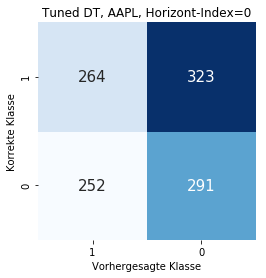

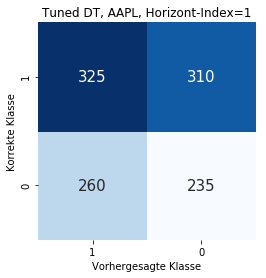

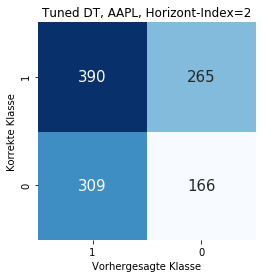

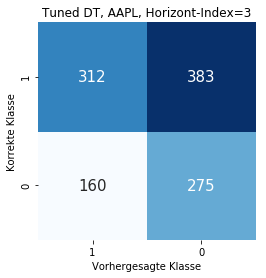

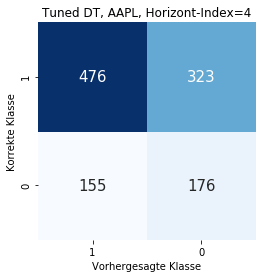

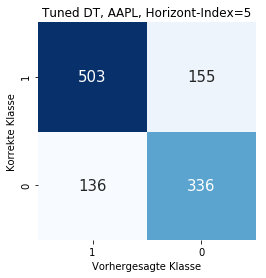

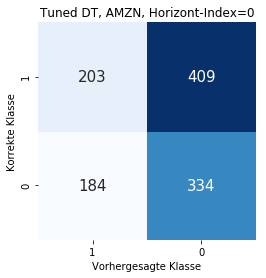

In [95]:
# Throw Dummy, DT, RF into get_tscv_confusion_matrices()
# dummy = DummyClassifier(random_state=RANDOM_SEED)
dt = DecisionTreeClassifier(random_state=RANDOM_SEED)
# rf = RandomForestClassifier(random_state=RANDOM_SEED)
get_tscv_confusion_matrices(dt)

# NExxt Steps: 
- Hyperparam Tuning einbauen
- Feature Improtances messen
- Fazit ziehen

# --------------------------------------------Ignore below------------------------------------------------

## 4.3 | Test master function
- Varying 4-5 dimensions simultaneously too complex, hence all but classifier is fixed in the master function
- TBD: Toggle Hyperparameter Tuning somewhere
- TBD: Correct testing for 0 values at the end, e.g. 365 horizon return in last week's data is always 0!! Must be accounted for

In [22]:
# TIME_HORIZONS = [1, 5, 10, 20, 65, 250] <- use index from 0 (1 trading day) to 5 (250 trading days) to determine time horizon
def master_function(time_horizon=2):
    # Create classifiers that are to be evaluated
    clf1 = DummyClassifier(random_state=42)
    clf2 = DecisionTreeClassifier(random_state=42)
    clf3 = RandomForestClassifier(n_estimators=10, random_state=42)
    clfs = [clf1, clf2, clf3]
    
    # Iterate over models & datasets to evaluate classifiers on each dataset
    for clf in clfs:
        cum_acc = 0
        for dataset_path in TECH_GROUP:
            # Load data and evaluate all models on it
            evaluate_models(dataset=dataset_path, extract_features=False, time_horizon=time_horizon)
            cum_acc = cum_acc + evaluate_models(dataset=dataset_path, extract_features=True, time_horizon=time_horizon)
        clf_avg_acc = cum_acc/len(TECH_GROUP)
        print("avg acc for " + str(type(clf)) + " is " + str(round(clf_avg_acc, 2)))

In [23]:
# master_function()

## 6.1.1 | Decision tree hyperparameter variation

In [ ]:
def evaluate_dt(filename=AAPL_DATA, extract_features=True, horizon_index=2):
    # Load data
    stock_ticker, X_train, X_test, y_train, y_test = generate_train_test_data(filename, extract_features, horizon_index, train_size=1)

    # Generate classifier
    clf = DecisionTreeClassifier(random_state=RANDOM_SEED)

    # Gather all plotted series to create master plot
    plotted_Xs = []
    plotted_ys_train = []
    plotted_ys_test = []

    # Evaluate classifier for different values of selected hyperparameter
    for i in [1, 3, 5, 6, 7, 9, 11, None]:
        clf.set_params(max_depth=i)
        X_res, y_train_res, y_test_res = plot_tscv_curve(clf, "Decision Tree Treffergenauigkeiten AAPL (MAX_DEPTH=" + str(i) + ")", X_train, y_train, save_fig=SAVE_FIG)
        print("Mean test accuracy for MAX_DEPTH=" + str(i) + ": " + str(round(np.mean(y_test_res), 3)))
        
        # Throw best params from 2.2 (Hyperparameter tuning) in and see if same result
        if i == 7:
            print("i is 7, so here we try the GRID_SEARCHED-best params: 'max_depth': 29, 'max_features': 29, 'min_samples_leaf': 1, 'min_samples_split': 15}, achieved 58.3% acc above")
            clf_best_params = DecisionTreeClassifier(random_state=RANDOM_SEED, max_depth=29, max_features=29, min_samples_leaf=1, min_samples_split=15)
            X_res, y_train_res, y_test_res = plot_tscv_curve(clf_best_params, "Decision Tree Treffergenauigkeiten AAPL (BEST_PARAMS)", X_train, y_train, save_fig=SAVE_FIG)
            print("Best-params DT achievend ACC=" + str(i) + ": " + str(round(np.mean(y_test_res), 3)))
        
        # TBD: Use all results to make master plot
        plotted_Xs.extend([X_res])
        plotted_ys_train.extend([y_train_res])
        plotted_ys_test.extend([y_test_res])

In [ ]:
# evaluate_dt(filename=AAPL_DATA, extract_features=True, horizon_index=2)

## 6.1.2 | Classifier horizon variation (averaged aross TECH_GROUP)

In [ ]:
def eval_avg_across_tech(clf):
    """
    Evaluates accuracy of given classifier for each time horizon (accuracy average cross TECH_GROUP)
    """
    accs_horizons = []
    for horizon in range(0, 6):
        accs_datasets = []
        for file in TECH_GROUP:
            # 1. Load data
            stock_ticker, X_train, X_test, y_train, y_test = generate_train_test_data(file, horizon_index=horizon, train_size=1)
            
            # 2. Evaluate classifier
            train_sizes_manual, train_scores_manual, test_scores_manual = apply_tscv(clf, X_train, y_train)
#             print("ACC for horizon=" + str(horizon) + " & file=" + str(file) + " is " + str(np.mean(test_scores_manual)))
            accs_datasets.extend([np.mean(test_scores_manual)])
        print("ACC for horizon=" + str(horizon) + " is " + str(np.mean(accs_datasets)))
        accs_horizons.extend([np.mean(accs_datasets)])

In [ ]:
# clf = DecisionTreeClassifier(random_state=RANDOM_SEED)
# eval_avg_across_tech(clf)

In [ ]:
# clf = RandomForestClassifier(random_state=RANDOM_SEED)
# eval_avg_across_tech(clf)

## 6.2 | Random forest hyperparameter variation

In [ ]:
def evaluate_rf(filename=AAPL_DATA, extract_features=True, horizon_index=2):
    # Load data
    stock_ticker, X_train, X_test, y_train, y_test = generate_train_test_data(filename, extract_features, horizon_index, train_size=1)

    # Generate classifier
    clf = RandomForestClassifier(n_estimators = 1, random_state=RANDOM_SEED)

    # Evaluate classifier for different values of selected hyperparameter
    for i in [1, 5, 10, 50, 100]:
        clf.set_params(n_estimators=i)
        X_res, y_train_res, y_test_res = plot_tscv_curve(clf, "Random Forest Treffergenauigkeiten AAPL (N_ESTIMATORS=" + str(i) + ")", X_train, y_train, save_fig=SAVE_FIG)
        print("Mean test accuracy for N_ESTIMATORS=" + str(i) + ": " + str(round(np.mean(y_test_res), 3)))

In [ ]:
# evaluate_rf(filename=MSFT_DATA, extract_features=True, horizon_index=2)

# Comparison table: Model-Extractets-Horizon

- DT auf AAPL: Bei Variierung von MAX_DEPTH ist MAX(EXTRACTEDS)=56.2 , MAX(NO EXTRACTEDS)=53.3